## 1) Setup

### Importing Dependencies

In [1]:
import cv2
import os
import random
import numpy as np
from matplotlib import pyplot as plt

C:\Users\yasha\anaconda3\lib\site-packages\numpy\_distributor_init.py:30: UserWarning: loaded more than 1 DLL from .libs:
C:\Users\yasha\anaconda3\lib\site-packages\numpy\.libs\libopenblas.EL2C6PLE4ZYW3ECEVIV3OXXGRN2NRFM2.gfortran-win_amd64.dll
C:\Users\yasha\anaconda3\lib\site-packages\numpy\.libs\libopenblas.WCDJNK7YVMPZQ2ME2ZZHJJRJ3JIKNDB7.gfortran-win_amd64.dll
  warnings.warn("loaded more than 1 DLL from .libs:"


In [2]:
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Layer, Conv2D, Dense, MaxPooling2D, Input, Flatten

### Setting up GPU Growth

In [3]:
#to avoid out of memory errors by setting GPU memory consumption growth
gpus = tf.config.experimental.list_physical_devices('GPU')
for gpu in gpus:
    tf.config.experimental.set_memory_growth(gpu, True)

### Creating Folder Structures

In [4]:
#Setting up paths
POS_PATH = os.path.join('data', 'positive')
NEG_PATH = os.path.join('data', 'negative')
ANC_PATH = os.path.join('data', 'anchor')

In [13]:
#Making the directories
os.makedirs(POS_PATH)
os.makedirs(NEG_PATH)
os.makedirs(ANC_PATH)

FileExistsError: [WinError 183] Cannot create a file when that file already exists: 'data\\positive'

## 2 ) Collecting positives and anchors

### Untaring Labelled Faces in the Wild Dataset

In [ ]:
#http://vis-www.cs.umass.edu/lfw/lfw.tgz

In [ ]:
#Uncompressing Tar GZ labelled Faces in the Wild Dataset
!tar -xf lfw.tgz

In [ ]:
# Moving LFW Images to the following repository data/negative
for directory in os.listdir('lfw'):
    for file in os.listdir(os.path.join('lfw', directory)):
        EX_PATH = os.path.join('lfw', directory, file)
        NEW_PATH = os.path.join(NEG_PATH, file)
        os.replace(EX_PATH, NEW_PATH)

### Collecting Positive and Anchor Classes

In [ ]:
#importing uuid library to generate unique image names
import uuid

In [ ]:
#Establishing a connection to the webcam
cap = cv2.VideoCapture(0)
while cap.isOpened():
    ret, frame = cap.read()
    
    #cutting down frame to 250 x 250 px
    frame = frame[120:120+250, 200:200+250, :]
    
    #collecting anchors
    if cv2.waitKey(1) & 0XFF == ord('a'):
        #creating the unique file path
        imgname = os.path.join(ANC_PATH, '{}.jpg'.format(uuid.uuid1()))
        #Writing out positive image
        cv2.imwrite(imgname, frame)
        
    #collecting positives
    if cv2.waitKey(1) & 0XFF == ord('p'):
        #creating the unique file path
        imgname = os.path.join(POS_PATH, '{}.jpg'.format(uuid.uuid1()))
        #Writing out positive image
        cv2.imwrite(imgname, frame)
        
    #showing image back to screen
    cv2.imshow('Image Collection', frame)
    
    #Breaking Gracefully
    if cv2.waitKey(1) & 0xFF == ord('q'):
        break
        
# Releasing the webcam
cap.release()
# Closing the image show frame
cv2.destroyAllWindows()

## 3 ) Loading and Preprocessing Images

### Getting Image Directories

In [5]:
anchor = tf.data.Dataset.list_files(ANC_PATH + '\*.jpg').take(400)
positive = tf.data.Dataset.list_files(POS_PATH + '\*.jpg').take(400)
negative = tf.data.Dataset.list_files(NEG_PATH + '\*.jpg').take(400)

### Preprocessing (Scaling and Resizing)

In [6]:
def preprocess(file_path):
    
    # Reading image from file path
    byte_img = tf.io.read_file(file_path)
    # Loading the image
    img = tf.io.decode_jpeg(byte_img)
    
    # Resizing the image to 100 x 100 x 3
    img = tf.image.resize(img, (105, 105))
    
    # Scaling image to be between 0 & 1
    img = img / 255.0
    
    # Returning image
    return img

### Creating Labelled Dataset

In [7]:
positives = tf.data.Dataset.zip((anchor, positive, tf.data.Dataset.from_tensor_slices(tf.ones(len(anchor)))))
negatives = tf.data.Dataset.zip((anchor, negative, tf.data.Dataset.from_tensor_slices(tf.zeros(len(anchor)))))
data = positives.concatenate(negatives)

### Building Train and Test Partition

In [8]:
def preprocess_twin(input_img, validation_img, label):
    return(preprocess(input_img), preprocess(validation_img), label)

In [9]:
# Buildind dataloader pipeline
data = data.map(preprocess_twin)
data = data.cache()
data = data.shuffle(buffer_size=10000)

In [10]:
# Training partition
train_data = data.take(round(len(data)*.7))
train_data = train_data.batch(16)
train_data = train_data.prefetch(8)

In [11]:
# Testing partition
test_data = data.skip(round(len(data)*.7))
test_data = test_data.take(round(len(data)*.3))
test_data = test_data.batch(16)
test_data = test_data.prefetch(8)

## 4 ) Model Engineering

### Building Embedding Layer

In [12]:
def make_embedding():
    inp = Input(shape=(105, 105, 3), name = 'input_image')
    
    # First Block
    c1 = Conv2D(64, (10, 10), activation = 'relu')(inp)
    m1 = MaxPooling2D(64, (2, 2), padding = 'same')(c1)
    
    # Second Block
    c2 = Conv2D(128, (7, 7), activation = 'relu')(m1)
    m2 = MaxPooling2D(64, (2, 2), padding = 'same')(c2)
    
    # Third Block
    c3 = Conv2D(128, (4, 4), activation = 'relu')(m2)
    m3 = MaxPooling2D(64, (2, 2), padding = 'same')(c3)
    
    # Final embedding block
    c4 = Conv2D(256, (4, 4), activation = 'relu')(m3)
    f1 = Flatten()(c4)
    d1 = Dense(4096, activation = 'sigmoid')(f1)
    
    
    return Model(inputs = [inp], outputs = [d1], name = 'embedding')

In [13]:
embedding = make_embedding()

In [14]:
embedding.summary()

Model: "embedding"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_image (InputLayer)     [(None, 105, 105, 3)]     0         
_________________________________________________________________
conv2d (Conv2D)              (None, 96, 96, 64)        19264     
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 48, 48, 64)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 42, 42, 128)       401536    
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 21, 21, 128)       0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 18, 18, 128)       262272    
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 9, 9, 128)         0 

### Building Distance Layer

In [15]:
# Siamese L1 Distance class
class L1Dist(Layer):
    def __init__(self, **kwargs):
        super().__init__()
    
    # Similarity Calculation
    def call(self, input_embedding, validation_embedding):
        return tf.math.abs(input_embedding - validation_embedding)

In [17]:
l1 = L1Dist()

### Making Siamese Model

In [16]:
def make_siamese_model():
    
    #Anchor image input in the network
    input_image = Input(name='input_img', shape=(105, 105, 3))
    
    #Validation image in the network
    validation_image = Input(name='validation_img', shape = (105, 105, 3))
    
    #Combininig siamese distance components
    siamese_layer = L1Dist()
    siamese_layer._name = 'distance'
    distances = siamese_layer(embedding(input_image), embedding(validation_image))
    
    #Classifier Layer
    classifier = Dense(1, activation = 'sigmoid')(distances)
    
    return Model(inputs = [input_image, validation_image], outputs = classifier, name = 'SiameseNetwork')

In [17]:
siamese_model = make_siamese_model()

In [18]:
siamese_model.summary()

Model: "SiameseNetwork"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_img (InputLayer)          [(None, 105, 105, 3) 0                                            
__________________________________________________________________________________________________
validation_img (InputLayer)     [(None, 105, 105, 3) 0                                            
__________________________________________________________________________________________________
embedding (Functional)          (None, 4096)         38960448    input_img[0][0]                  
                                                                 validation_img[0][0]             
__________________________________________________________________________________________________
distance (L1Dist)               (None, 4096)         0           embedding[0][0]     

## 5 ) Training

### Setting up Loss and Optimizer

In [19]:
binary_cross_loss = tf.losses.BinaryCrossentropy()

In [20]:
opt = tf.keras.optimizers.Adam(1e-4)

### Establishing Checkpoints 

In [21]:
checkpoint_dir = './training_checkpoints'
checkpoint_prefix = os.path.join(checkpoint_dir, 'ckpt')
checkpoint = tf.train.Checkpoint(opt = opt, siamese_model = siamese_model)

### Building train step function

In [22]:
@tf.function
def train_step(batch):
    
    #Record all of our operations
    with tf.GradientTape() as tape:
        
        #Get anchor and positive/negative image
        X = batch[:2]
        #Get label
        y = batch[2]
        
        #Forward pass
        yhat = siamese_model(X, training=True)
        
        #Calculating Loss
        loss = binary_cross_loss(y, yhat)
    print(loss)
    
    #Calculating Gradients
    grad = tape.gradient(loss, siamese_model.trainable_variables)
    
    #Calculating updated weights and apply to siamese model
    opt.apply_gradients(zip(grad, siamese_model.trainable_variables))
    
    #Return Loss
    return loss

### Building Training Loop 

In [23]:
#Importing metric calculations
from tensorflow.keras.metrics import Precision, Recall

In [24]:
def train(data, EPOCHS):
    #Looping through epochs
    for epoch in range(1, EPOCHS+1):
        print('\n Epoch {}/{}'.format(epoch, EPOCHS))
        progbar = tf.keras.utils.Progbar(len(data))
        
        #Creating a metric object
        r = Recall()
        p = Precision()
        
        #Looping through each batch
        for idx, batch in enumerate(data):
            #Run train step here
            loss = train_step(batch)
            yhat = siamese_model.predict(batch[:2])
            r.update_state(batch[2], yhat)
            p.update_state(batch[2], yhat)
            progbar.update(idx+1)
            
        print(loss.numpy(), r.result().numpy(), p.result().numpy())
        
        #Save checkpoints
        if epoch % 10 == 0:
            checkpoint.save(file_prefix=checkpoint_prefix)
            

In [25]:
EPOCHS = 50

In [26]:
train(train_data, EPOCHS)


 Epoch 1/50
Tensor("binary_crossentropy/weighted_loss/value:0", shape=(), dtype=float32)
Tensor("binary_crossentropy/weighted_loss/value:0", shape=(), dtype=float32)
35/35 [==============================] - 36s 522ms/step
0.19892022 0.4334471 1.0

 Epoch 2/50
35/35 [==============================] - 18s 511ms/step
0.061851494 0.98550725 1.0

 Epoch 3/50
35/35 [==============================] - 18s 509ms/step
0.07490529 0.9965157 1.0

 Epoch 4/50
 1/35 [..............................] - ETA: 17s

KeyboardInterrupt: 

## 6 ) Evaluating Model

### Making Predictions

In [25]:
#Getting a batch of test data
test_input, test_val, y_true = test_data.as_numpy_iterator().next()

In [26]:
y_hat = siamese_model.predict([test_input, test_val])

In [27]:
#post processing the results
[1 if prediction > 0.5 else 0 for prediction in y_hat]

[1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 1, 1, 0, 1, 0]

In [28]:
y_true

array([1., 0., 0., 0., 1., 0., 0., 0., 0., 1., 0., 1., 1., 0., 1., 0.],
      dtype=float32)

### Calculating Metrics 

In [29]:
r = Recall()
p = Precision()

for test_input, test_val, y_true in test_data.as_numpy_iterator():
    yhat = siamese_model.predict([test_input, test_val])
    r.update_state(y_true, yhat)
    p.update_state(y_true, yhat)
print(r.result().numpy(), p.result().numpy())

1.0 1.0


### Vizualising the results 

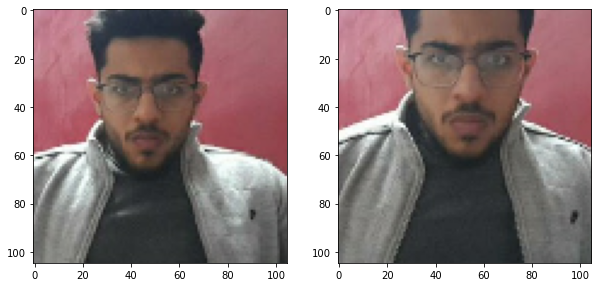

In [30]:
# Setting plot size
plt.figure(figsize=(10, 8))

# Setting first subplot
plt.subplot(1, 2, 1)
plt.imshow(test_input[10])

# Set second subplot
plt.subplot(1, 2, 2)
plt.imshow(test_val[9])

plt.show()

### 7 ) Saving model

In [34]:
# Saving Weights
siamese_model.save('siamesemodelv1.h5')

In [24]:
# Reloading model
siamese_model = tf.keras.models.load_model('siamesemodelv1.h5',
                                          custom_objects={'L1Dist': L1Dist, 'BinaryCrossentropy':tf.losses.BinaryCrossentropy})

In [31]:
# Making predictions with reloaded model
siamese_model.predict([test_input, test_val])

array([[9.9999952e-01],
       [1.0000000e+00],
       [9.9999988e-01],
       [1.1865001e-10],
       [1.4561576e-11],
       [3.7199153e-09],
       [3.4425123e-09],
       [1.0000000e+00],
       [4.9340328e-12],
       [1.0000000e+00],
       [1.0000000e+00],
       [9.9980968e-01],
       [5.6084122e-07],
       [2.5182616e-11],
       [1.0000000e+00],
       [9.9990785e-01]], dtype=float32)

In [32]:
siamese_model.summary()

Model: "SiameseNetwork"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_img (InputLayer)          [(None, 105, 105, 3) 0                                            
__________________________________________________________________________________________________
validation_img (InputLayer)     [(None, 105, 105, 3) 0                                            
__________________________________________________________________________________________________
embedding (Functional)          (None, 4096)         38960448    input_img[0][0]                  
                                                                 validation_img[0][0]             
__________________________________________________________________________________________________
l1_dist_1 (L1Dist)              (None, 4096)         0           embedding[0][0]     

## Real Time Test

### Verification Function 

In [33]:
def verify(model, detection_threshold, verification_threshold):
    #Building result array
    results = []
    for image in os.listdir(os.path.join('application_data', 'verification_image')):
        input_img = preprocess(os.path.join('application_data', 'input_image', 'input_image.jpg'))
        validation_img = preprocess(os.path.join('application_data', 'verification_image', image))
        
        #Making Predictions
        result = model.predict(list(np.expand_dims([input_img, validation_img], axis=1)))
        results.append(result)
        
    detection = np.sum(np.array(results) > detection_threshold)
    
    verification = detection / len(os.listdir(os.path.join('application_data', 'verification_image')))
    verified = verification > verification_threshold
    
    return results, verified

### OpenCV Real Time Verification

In [34]:
cap = cv2.VideoCapture(1)
while cap.isOpened():
    ret, frame = cap.read()
    frame = frame[120:120+250, 200:200+250, :]
    
    cv2.imshow('Verification', frame)
    
    #verification trigger
    if cv2.waitKey(10) & 0xFF== ord('v'):
        #Save input image to application_data/input_image folder
        hsv = cv2.cvtColor(frame, cv2.COLOR_BGR2HSV)
        h, s, v = cv2.split(hsv)
        
        lim = 255 - 10
        v[v > lim] = 255
        v[v <= lim] -= 10
        
        final_hsv = cv2.merge((h, s, v))
        img = cv2.cvtColor(final_hsv, cv2.COLOR_HSV2BGR)
        
        cv2.imwrite(os.path.join('application_data', 'input_image', 'input_image.jpg'), frame)
        # Run verification
        results, verified = verify(siamese_model, 0.5, 0.5)
        print(verified)
        
    if cv2.waitKey(10) & 0xFF == ord('q'):
        break
        
cap.release()
cv2.destroyAllWindows()

False
True
False
False
True
False
